In [60]:
import pandas as pd
import random 
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import itertools
# # The following line is needed to show plots inline in notebooks
# %matplotlib inline 
# from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

# from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import learning_curve
# import seaborn as sns
# sns.set_style('whitegrid')
# import statsmodels.api as sm
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import RFE
# import warnings
# warnings.filterwarnings("ignore")

# # Import the necessary libraries first
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# from sklearn.decomposition import PCA

### Refer to https://www.datacamp.com/community/tutorials/scikit-learn-fake-news

In [2]:
basePath = os.path.dirname(os.path.abspath("train.json"))
# 0:false, 1:partly true, 2:true
claim = pd.read_json(open(basePath + "/train/train.json", "r", encoding="utf8"))
claim.head(5)

,claim,claimant,date,id,label,related_articles
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [3]:
txtPath = basePath+"/train/train_articles/"

In [4]:
def appendArticles(articleList, basePath):
    contents = ''
    for articleNumber in articleList:
        f = open(basePath+str(articleNumber)+".txt", "r")
        contents = f.read()+";"+contents
        f.close()
    return contents

In [5]:
claim['articleText'] = claim.apply(lambda row: appendArticles(row['related_articles'], txtPath) ,axis=1)

In [6]:
def assignLength(row, colName):
    return len(row[colName])

In [7]:
claim['articleLength'] = claim.apply(lambda row: assignLength(row, 'articleText'), axis=1)
claim.head(3)

,claim,claimant,date,id,label,related_articles,articleText,articleLength
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]",1984 by George Orwell\n1984 is a dystopian nov...,7043
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]",Maine candidate apologizes after calling Parkl...,9447
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]",About Kennedy Space Center Visitor Complex\nDe...,16891


In [8]:
y = claim['label']
# Drop the `label` column
claim = claim.drop("label", axis=1)
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(claim['articleText'], y, test_size=0.33, random_state=53)

In [11]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [12]:
# Get the feature names of `tfidf_vectorizer` 
print(count_vectorizer.get_feature_names()[-10:])

['ﻼد', 'ﻼﺗﻪ', '𝑩𝒓𝒂𝒕𝒎𝒂𝒏', '𝑫𝒐𝒖𝒈', '𝔸𝕡𝕖𝕝', '𝕁ℙ', '𝕄𝕔𝔾𝕝𝕠𝕟𝕖', '𝕋𝕙𝕖𝕣𝕖𝕤𝕖', '𝖑𝖎𝖑𝖆', '𝖗𝖔𝖘𝖎𝖊']


In [13]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [14]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

['ﻼد', 'ﻼﺗﻪ', '𝑩𝒓𝒂𝒕𝒎𝒂𝒏', '𝑫𝒐𝒖𝒈', '𝔸𝕡𝕖𝕝', '𝕁ℙ', '𝕄𝕔𝔾𝕝𝕠𝕟𝕖', '𝕋𝕙𝕖𝕣𝕖𝕤𝕖', '𝖑𝖎𝖑𝖆', '𝖗𝖔𝖘𝖎𝖊']


In [15]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

In [16]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [21]:
difference1 = set(count_df.columns) - set(tfidf_df.columns)
difference1

{'did',
 'including',
 'just',
 'like',
 'make',
 'new',
 'people',
 'president',
 'public',
 'said',
 'state',
 'states',
 'time',
 'way',
 'year',
 'years'}

In [23]:
difference2 = set(tfidf_df.columns) - set(count_df.columns)
difference2

set()

In [24]:
print(count_df.equals(tfidf_df))

False


In [31]:
y_test

13908    0
2310     0
2763     0
312      0
5242     0
121      1
5423     1
2568     1
13436    1
230      0
1008     0
10318    0
12500    1
11968    1
9276     0
5228     2
14151    0
12228    1
10958    1
14503    1
11798    0
12737    1
116      0
10206    2
7871     1
3125     0
5316     1
13849    0
8679     2
575      0
        ..
11364    2
12106    0
2525     0
1330     0
4135     0
906      0
12362    0
5392     0
12445    0
10548    0
6206     0
4996     0
13503    1
3919     1
6936     0
10670    0
11872    0
11602    2
839      0
13695    1
9136     1
8122     0
8742     0
81       2
6442     0
3356     1
12778    1
11947    0
11491    1
14300    0
Name: label, Length: 5134, dtype: int64

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Bag of words feature

In [25]:
clf = MultinomialNB() 

In [41]:
y_test.shape

(5134,)

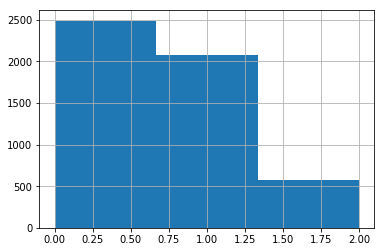

In [39]:
y_test.hist(bins=3)

accuracy:   0.580
Confusion matrix, without normalization


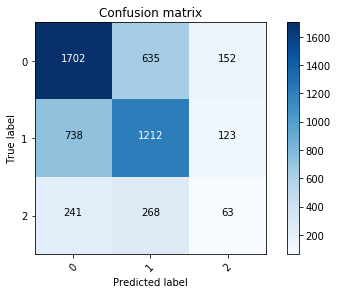

In [42]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=[0, 1, 2])
plot_confusion_matrix(cm, classes=[0, 1, 2])

tf-idf features

In [43]:
clf = MultinomialNB() 

accuracy:   0.590
Confusion matrix, without normalization


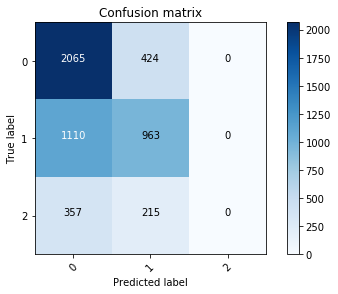

In [50]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=[0, 1, 2])
plot_confusion_matrix(cm, classes=[0, 1, 2])

PassiveAggressiveClassifier

In [64]:
linear_clf = PassiveAggressiveClassifier(tol=50)

accuracy:   0.578
Confusion matrix, without normalization


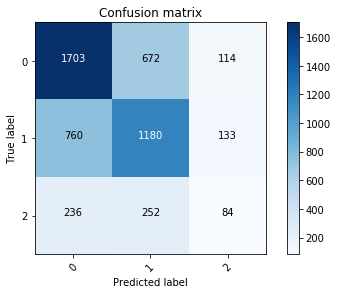

In [65]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=[0, 1, 2])
plot_confusion_matrix(cm, classes=[0, 1, 2])

Testing alpha

In [66]:
clf = MultinomialNB(alpha=0.1)

In [69]:
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

/Users/pingwu/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00 Score: 0.60538
Alpha: 0.10 Score: 0.60771
Alpha: 0.20 Score: 0.60596
Alpha: 0.30 Score: 0.60382
Alpha: 0.40 Score: 0.59914
Alpha: 0.50 Score: 0.59758
Alpha: 0.60 Score: 0.59564
Alpha: 0.70 Score: 0.59427
Alpha: 0.80 Score: 0.59213
Alpha: 0.90 Score: 0.58979
